In [1]:
# Data handling modules
import pandas as pd
import numpy as np
import geopandas as gpd 

# Statistic modules
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler

from rasterio.enums import Resampling, MergeAlg
from rasterio import features
import functools

# Cluster modules
from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabasz_score
from sklearn.cluster import KMeans

# Plotting and mapping modules
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import warnings
warnings.filterwarnings("ignore")

# Custom functions for array to raster and raster to vector operations
from process_functions import *

C:\Users\Sarah\anaconda3\envs\mygeos_cartopy\lib\site-packages\geopandas\_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
df=pd.read_csv('C:/Users/Sarah/OneDrive - Kansas State University/Desktop/scripts_jp/agroecology_paper/data_processing/final_processing/final_post_patrignani_adjustments/variables.csv',index_col=0)

In [3]:
df.head()

,paws_050,om_kg_sq_m,pet,precip,temp,depth_adj
0,NaN,NaN,1294.5751,462.50003,10.630000,NaN
1,NaN,NaN,1294.4749,462.08603,10.600000,NaN
2,NaN,NaN,1294.2855,461.64902,10.650001,NaN
3,NaN,NaN,1293.9469,461.27800,10.660001,NaN
4,NaN,NaN,1293.4641,460.93002,10.710000,NaN


In [4]:
df = df[['paws_050', 'om_kg_sq_m', 'depth_adj']]

In [5]:
# Obtain Index for non_null values 
null_idx= df[df.isnull().any(axis=1)].index
non_null_idx = df[~df.isnull().any(axis=1)].index

df.iloc[non_null_idx].head(3)

,paws_050,om_kg_sq_m,depth_adj
897,11.0,15.0,35.645320
898,10.0,12.0,47.127870
899,8.0,13.0,59.862305


In [6]:
X = df.loc[non_null_idx] # only use non nan values. The irregular bounds of Kansas have nan values. 

# Normalize the values with scaling
scaler= MinMaxScaler()
X= scaler.fit_transform(X)

# PCA at 95% did not change shape

In [13]:
# Kmeans loop to evaluate performance of various cluster numbers for a macro climate cluster
print ('Performance of Kmeans models')
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for n_clusters in range_n_clusters:
    clusters = KMeans(n_clusters)            
    cluster_labels = clusters.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels, metric='sqeuclidean')
    CHS_avg = calinski_harabasz_score(X, cluster_labels)
    print("For", n_clusters, "clusters",
          "silhouette score is:", round(silhouette_avg,2),
          "and the calinski harabasz score is:", round(CHS_avg,2))

Performance of Kmeans models
For 2 clusters silhouette score is: 0.49 and the calinski harabasz score is: 133187.79
For 3 clusters silhouette score is: 0.51 and the calinski harabasz score is: 157951.28
For 4 clusters silhouette score is: 0.5 and the calinski harabasz score is: 165718.0
For 5 clusters silhouette score is: 0.55 and the calinski harabasz score is: 187495.44
For 6 clusters silhouette score is: 0.54 and the calinski harabasz score is: 183995.21
For 7 clusters silhouette score is: 0.54 and the calinski harabasz score is: 180260.24
For 8 clusters silhouette score is: 0.55 and the calinski harabasz score is: 175928.52


In [7]:
# Fit 7 
clusters = KMeans(n_clusters=7, random_state= 7)            
kmean_7_cluster = clusters.fit_predict(X)

In [8]:
# Conver to array as input to raster file 
df.loc[non_null_idx,'cluster'] = kmean_7_cluster + 1 # 1 is added so that the first cluster is 1 instead of 0 
df.iloc[3000:3005].head(3)
cluster = df.cluster.to_numpy() 
cluster = np.nan_to_num(cluster, nan=0)

new_height = 362
new_width = 896

cluster= np.reshape(cluster, (new_height, new_width))

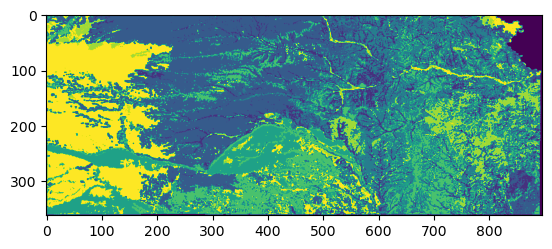

In [38]:
plt.imshow(cluster)

In [39]:
np.unique(cluster)

array([0., 1., 2., 3., 4., 5., 6., 7.])

In [9]:
# Load Validation Data 
method = Resampling.mode
ld_class= rasterio.open('C:/Users/Sarah/OneDrive - Kansas State University/Desktop/code/ks_agro_climate/land_class_wgs84_ks.tif').read(1, out_shape=(1,new_height, new_width), resampling=method)

[0. 1. 2. 3. 4. 5. 6. 7. 8.]


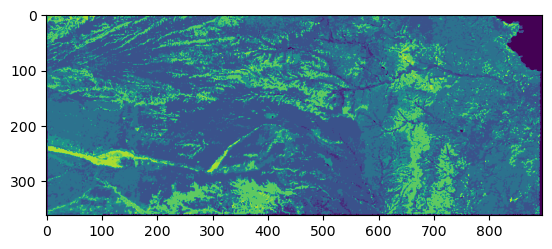

In [10]:
plt.imshow(ld_class)
print(np.unique(ld_class))

In [11]:
mask = (ld_class == 0)| (cluster == 0)

X = cluster[~mask].flatten().reshape(-1, 1)
y = ld_class[~mask].flatten().astype(int)

In [12]:
def MultiNomial (x,y, class_weights, empty_dic): 
    X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.25, random_state=2, stratify=y)

    # Select Optimal Model Parameters
    #model = LinearRegression()
    model = LogisticRegression() 

    # Set a CV to be utilized
    cv = 10

    # Set Paramters
    parameters = {'penalty' : [ 'none', 'l2', ], #
                  'solver' : ['lbfgs',  'saga' 'newton-cg', ,   'sag'], #,
                  'max_iter':[500, 1000], #
                #  'multi_class':['multinomial'], 
                  'class_weight':[class_weight], 
                 }
    params_ = GridSearchCV(estimator=model, param_grid = parameters, cv = cv, n_jobs=-1)
    params_.fit(X_train, y_train)
    print(params_.best_params_)
    empty_dic['parameters'] = params_.best_params_
    
    # Evaluate Model
    scores = cross_validate(LogisticRegression(**params_.best_params_), X_test, y_test, cv = 10,
               scoring=['r2', 'neg_mean_squared_error', 'accuracy', 'mutual_info_score'])
    for key,vals in scores.items():
        print("Average for {} is {}".format(key,round(np.mean(vals),2)))
    empty_dic['scores'] = scores
        
    # Classification Report 
    logmodel_macro = LogisticRegression(**params_.best_params_, random_state=2) 
    logmodel_macro.fit(X_train, y_train)

    predictions=logmodel_macro.predict(X_test)
    empty_dic['y_trues'] = y_test
    empty_dic['y_preds']=  predictions
    empty_dic['model'] = logmodel_macro 
    
    print(classification_report(y_test,  predictions))

**Use land class to validate 7 Cluster Labels w/3 soil variables**

In [66]:
results = {}

class_weight = {1:np.count_nonzero(y== 1)/np.count_nonzero(y),2:np.count_nonzero(y== 2)/np.count_nonzero(y), 3:np.count_nonzero(y== 3)/np.count_nonzero(y), 
               4:np.count_nonzero(y== 4)/np.count_nonzero(y),5:np.count_nonzero(y== 5)/np.count_nonzero(y), 6:np.count_nonzero(y== 6)/np.count_nonzero(y),
               7:np.count_nonzero(y== 7)/np.count_nonzero(y),8:np.count_nonzero(y== 8)/np.count_nonzero(y)} # class weights


MultiNomial (X,y, class_weight, results)

{'class_weight': {1: 0.013379511251892276, 2: 0.41790698266101844, 3: 0.3347771883626557, 4: 0.056895520869111676, 5: 0.0017428029869353383, 6: 0.1609135086313272, 7: 0.014152323525296086, 8: 0.0002321617117632841}, 'max_iter': 500, 'penalty': 'l2', 'solver': 'lbfgs'}
Average for fit_time is 14.49
Average for score_time is 0.0
Average for test_r2 is -0.61
Average for test_neg_mean_squared_error is -3.53
Average for test_accuracy is 0.42
Average for test_mutual_info_score is 0.0
              precision    recall  f1-score   support

           1       0.00      0.00      0.00      1052
           2       0.42      1.00      0.59     32851
           3       0.00      0.00      0.00     26317
           4       0.00      0.00      0.00      4473
           5       0.00      0.00      0.00       137
           6       0.00      0.00      0.00     12649
           7       0.00      0.00      0.00      1112
           8       0.00      0.00      0.00        18

    accuracy                 

**Predicting Land Uses w/ 3 variables**

In [13]:
mask = (ld_class == 0)

X = cluster[~mask].flatten().reshape(-1, 1)
y = ld_class[~mask].flatten().astype(int)

In [75]:
results = {}

class_weight = {1:np.count_nonzero(y== 1)/np.count_nonzero(y),2:np.count_nonzero(y== 2)/np.count_nonzero(y), 3:np.count_nonzero(y== 3)/np.count_nonzero(y), 
               4:np.count_nonzero(y== 4)/np.count_nonzero(y),5:np.count_nonzero(y== 5)/np.count_nonzero(y), 6:np.count_nonzero(y== 6)/np.count_nonzero(y),
               7:np.count_nonzero(y== 7)/np.count_nonzero(y),8:np.count_nonzero(y== 8)/np.count_nonzero(y)} # class weights


MultiNomial (X,y, class_weight, results)

{'class_weight': {1: 0.013370029142659196, 2: 0.41785869782844287, 3: 0.3347306131399388, 4: 0.05690922554257148, 5: 0.0017447458995293317, 6: 0.16097743906896037, 7: 0.014177252200000635, 8: 0.00023199717789734283}, 'max_iter': 500, 'penalty': 'l2', 'solver': 'lbfgs'}
Average for fit_time is 17.19
Average for score_time is 0.0
Average for test_r2 is -0.61
Average for test_neg_mean_squared_error is -3.53
Average for test_accuracy is 0.42
Average for test_mutual_info_score is 0.0
              precision    recall  f1-score   support

           1       0.00      0.00      0.00      1052
           2       0.42      1.00      0.59     32871
           3       0.00      0.00      0.00     26332
           4       0.00      0.00      0.00      4477
           5       0.00      0.00      0.00       137
           6       0.00      0.00      0.00     12663
           7       0.00      0.00      0.00      1115
           8       0.00      0.00      0.00        18

    accuracy                

**Evaluate Land Class Labels w/Validation Data Set Used for Macro-Micro**

In [20]:
# Insurance Data
fp= r"C:\Users\Sarah\OneDrive - Kansas State University\Desktop\scripts_jp/agroecology_paper/data_processing/final_processing/loss_type_per.shape" # state shape file. 
loss_type = gpd.read_file(fp)
loss_type.to_crs(4326, inplace = True)
print(loss_type.shape==cluster.shape)
loss_type.head(3)

# Convert Vector Geopandas to a List of Numpy Arrays in the Same Spatial Domain as Clusters
value_list = ['Cold Wet W', 'Cold Winte', 'Drought', 'Excess Moi', 'Flood', 'Freeze', 'Frost', 'Hail', 'Heat', 'Hot Wind', 'Insects', 'Plant Dise', 'Wind/Exces']

loss_list = []
template = rasterio.open(r'C:\Users\Sarah\OneDrive - Kansas State University\Desktop\code\ks_agro_climate\cluster.tif')

for i in value_list: 
    geom_value = ((geom,value) for geom, value in zip(loss_type.geometry, loss_type[i]))
    rasterized = features.rasterize(geom_value,
                                out_shape = template.shape,
                                transform = template.transform,
                                all_touched = True,
                                fill = -9999,   # background value
                                merge_alg = MergeAlg.replace,
                                dtype = np.float32)
    loss_list.append(rasterized) 

False


In [15]:
# Crop Rotation Data
ks_2022= rasterio.open(r"C:\Users\Sarah\OneDrive - Kansas State University\Desktop\code\ks_agro_climate\2022wgs84_ks_scaled.tif").read(1)
ks_2021= rasterio.open(r"C:\Users\Sarah\OneDrive - Kansas State University\Desktop\code\ks_agro_climate\2021wgs84_ks_scaled.tif").read(1)
ks_2020= rasterio.open(r"C:\Users\Sarah\OneDrive - Kansas State University\Desktop\code\ks_agro_climate\2020wgs84_ks_scaled.tif").read(1)     
ks_2019= rasterio.open(r"C:\Users\Sarah\OneDrive - Kansas State University\Desktop\code\ks_agro_climate\2019wgs84_ks_scaled.tif").read(1)
ks_2018= rasterio.open(r"C:\Users\Sarah\OneDrive - Kansas State University\Desktop\code\ks_agro_climate\2018wgs84_ks_scaled.tif").read(1)
ks_2017= rasterio.open(r"C:\Users\Sarah\OneDrive - Kansas State University\Desktop\code\ks_agro_climate\2017wgs84_ks_scaled.tif").read(1)
ks_2016= rasterio.open(r"C:\Users\Sarah\OneDrive - Kansas State University\Desktop\code\ks_agro_climate\2016wgs84_ks_scaled.tif").read(1)    
ks_2015= rasterio.open(r"C:\Users\Sarah\OneDrive - Kansas State University\Desktop\code\ks_agro_climate\2015wgs84_ks_scaled.tif").read(1)
ks_2014= rasterio.open(r"C:\Users\Sarah\OneDrive - Kansas State University\Desktop\code\ks_agro_climate\2014wgs84_ks_scaled.tif").read(1)
ks_2013= rasterio.open(r"C:\Users\Sarah\OneDrive - Kansas State University\Desktop\code\ks_agro_climate\2013wgs84_ks_scaled.tif").read(1)

rotation = np.stack(( ks_2022, ks_2021, ks_2020, ks_2019, ks_2018, ks_2017, ks_2016, ks_2015, ks_2014, ks_2013))

In [16]:
# Function to mask for specific crop values
def CropCount(np_array, vals):
    mask = functools.reduce(np.logical_or, (np_array==val for val in vals))
    non_crop = (np.where(mask, 1,0)).astype(dtype=np.uint8)
    return non_crop 

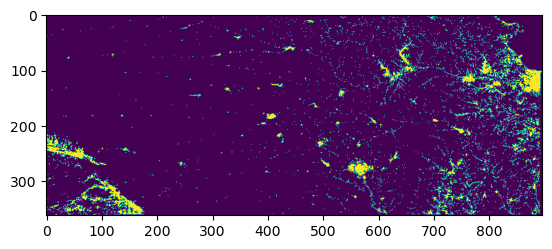

In [17]:
# Create a Boolean for Non crop and Non crop plus grass values
ks_non_crop = CropCount(ks_2022,[63, 64, 65, 111,112, 121, 122, 123, 124, 131, 141, 142, 143, 152, 190, 195])
ks_non_crop_grass = CropCount(ks_2022,[63, 64, 65, 111,112, 121, 122, 123, 124, 131, 141, 142, 143, 152, 176,  190, 195])
plt.imshow(ks_non_crop)

In [18]:
# Calculate refrequency of crop planted for the 10 year period
wheat = [CropCount(r, [24]) for r in rotation]
wheat = sum(wheat)

corn = [CropCount(r, [1]) for r in rotation]
corn = sum(corn)

soybeans = [CropCount(r, [5]) for r in rotation]
soybeans = sum(soybeans)

fallow = [CropCount(r, [61]) for r in rotation]
fallow = sum(fallow)

sorghum = [CropCount(r, [4]) for r in rotation]
sorghum = sum(sorghum)

wht_soy = [CropCount(r, [26]) for r in rotation]
wht_soy= sum(wht_soy)

alfalfa = [CropCount(r, [36]) for r in rotation]
alfalfa= sum(alfalfa)

other_hay = [CropCount(r, [37]) for r in rotation]
other_hay= sum(other_hay)

triticale = [CropCount(r, [205]) for r in rotation]
triticale= sum(triticale)

cotton = [CropCount(r, [2]) for r in rotation]
cotton= sum(cotton)

cotton = [CropCount(r, [2]) for r in rotation]
cotton= sum(cotton)

grassland = [CropCount(r, [176]) for r in rotation]
grassland = sum(grassland)

In [21]:
# This does include grassland
# Create mask 
mask= (cluster == 0) | (ks_non_crop == 1) |(loss_list[0] ==-9999)

cluster_m = cluster[~mask]
macro = np.round(cluster_m/10,0)

crop_features =[wheat, corn, soybeans, fallow, sorghum, wht_soy, alfalfa, other_hay, triticale, cotton, grassland]
feature_list = crop_features+loss_list
crop_features_m = [f[~mask] for f in feature_list]

y = ld_class[~mask].flatten().astype(int)

**Validation Model with predicted as land classes, and predictors as n=24 w/13 loss causes, 11 land covers (10 crops, grass land)**

In [92]:
results = {}

class_weight = {1:np.count_nonzero(y== 1)/np.count_nonzero(y),2:np.count_nonzero(y== 2)/np.count_nonzero(y), 3:np.count_nonzero(y== 3)/np.count_nonzero(y), 
               4:np.count_nonzero(y== 4)/np.count_nonzero(y),5:np.count_nonzero(y== 5)/np.count_nonzero(y), 6:np.count_nonzero(y== 6)/np.count_nonzero(y),
               7:np.count_nonzero(y== 7)/np.count_nonzero(y),8:np.count_nonzero(y== 8)/np.count_nonzero(y)} # class weights


# This includes grassland w/24 variables
X = np.stack((crop_features_m[0].flatten(),crop_features_m[1].flatten(),crop_features_m[2].flatten(),crop_features_m[3].flatten(), crop_features_m[4].flatten(), crop_features_m[5].flatten(), 
              crop_features_m[6].flatten(), crop_features_m[7].flatten(), crop_features_m[8].flatten(),crop_features_m[9].flatten(), crop_features_m[10].flatten(), crop_features_m[11].flatten(), 
              crop_features_m[12].flatten(), crop_features_m[13].flatten(), crop_features_m[14].flatten(),crop_features_m[15].flatten(), crop_features_m[16].flatten(), crop_features_m[17].flatten(), 
               crop_features_m[18].flatten(), crop_features_m[19].flatten(), crop_features_m[20].flatten(),crop_features_m[21].flatten(), crop_features_m[22].flatten(), crop_features_m[23].flatten()), axis=1)

X = MinMaxScaler().fit_transform(X) 


MultiNomial (X,y, class_weight, results)

{'class_weight': {1: 0.012761283563426215, 2: 0.4260768177900945, 3: 0.33501073015765725, 4: 0.054968823400192636, 5: 0.0012673414555839065, 6: 0.1587759171327667, 7: 0.011000523834468309, 8: 0.0001385626658105071}, 'max_iter': 500, 'penalty': 'none', 'solver': 'lbfgs'}
Average for fit_time is 18.99
Average for score_time is 0.01
Average for test_r2 is -0.22
Average for test_neg_mean_squared_error is -2.65
Average for test_accuracy is 0.53
Average for test_mutual_info_score is 0.07
              precision    recall  f1-score   support

           0       0.56      0.01      0.03       367
           1       0.00      0.00      0.00       944
           2       0.55      0.81      0.66     31519
           3       0.49      0.54      0.52     24782
           4       0.00      0.00      0.00      4066
           5       0.00      0.00      0.00        94
           6       0.48      0.04      0.07     11745
           7       0.00      0.00      0.00       814
           8       0.00   

**Identical to above except addition of macro cluster label as a predictor**

In [23]:
results = {}

class_weight = {1:np.count_nonzero(y== 1)/np.count_nonzero(y),2:np.count_nonzero(y== 2)/np.count_nonzero(y), 3:np.count_nonzero(y== 3)/np.count_nonzero(y), 
               4:np.count_nonzero(y== 4)/np.count_nonzero(y),5:np.count_nonzero(y== 5)/np.count_nonzero(y), 6:np.count_nonzero(y== 6)/np.count_nonzero(y),
               7:np.count_nonzero(y== 7)/np.count_nonzero(y),8:np.count_nonzero(y== 8)/np.count_nonzero(y)} # class weights


# This includes grassland w/24 variables
X = np.stack((macro.flatten(), crop_features_m[0].flatten(),crop_features_m[1].flatten(),crop_features_m[2].flatten(),crop_features_m[3].flatten(), crop_features_m[4].flatten(), crop_features_m[5].flatten(), 
              crop_features_m[6].flatten(), crop_features_m[7].flatten(), crop_features_m[8].flatten(),crop_features_m[9].flatten(), crop_features_m[10].flatten(), crop_features_m[11].flatten(), 
              crop_features_m[12].flatten(), crop_features_m[13].flatten(), crop_features_m[14].flatten(),crop_features_m[15].flatten(), crop_features_m[16].flatten(), crop_features_m[17].flatten(), 
               crop_features_m[18].flatten(), crop_features_m[19].flatten(), crop_features_m[20].flatten(),crop_features_m[21].flatten(), crop_features_m[22].flatten(), crop_features_m[23].flatten()), axis=1)

X = MinMaxScaler().fit_transform(X) 


MultiNomial (X,y, class_weight, results)

{'class_weight': {1: 0.012761283563426215, 2: 0.4260768177900945, 3: 0.33501073015765725, 4: 0.054968823400192636, 5: 0.0012673414555839065, 6: 0.1587759171327667, 7: 0.011000523834468309, 8: 0.0001385626658105071}, 'max_iter': 500, 'penalty': 'none', 'solver': 'lbfgs'}
Average for fit_time is 19.8
Average for score_time is 0.01
Average for test_r2 is -0.17
Average for test_neg_mean_squared_error is -2.53
Average for test_accuracy is 0.54
Average for test_mutual_info_score is 0.08
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       367
           1       0.00      0.00      0.00       944
           2       0.57      0.82      0.67     31519
           3       0.49      0.55      0.52     24782
           4       0.00      0.00      0.00      4066
           5       0.00      0.00      0.00        94
           6       0.57      0.08      0.13     11745
           7       0.00      0.00      0.00       814
           8       0.00    

**Validation Model with predicted as land classes, and predictors as n=24 w/13 loss causes, 1 land covers ( grass land)**

In [93]:
results = {}

class_weight = {1:np.count_nonzero(y== 1)/np.count_nonzero(y),2:np.count_nonzero(y== 2)/np.count_nonzero(y), 3:np.count_nonzero(y== 3)/np.count_nonzero(y), 
               4:np.count_nonzero(y== 4)/np.count_nonzero(y),5:np.count_nonzero(y== 5)/np.count_nonzero(y), 6:np.count_nonzero(y== 6)/np.count_nonzero(y),
               7:np.count_nonzero(y== 7)/np.count_nonzero(y),8:np.count_nonzero(y== 8)/np.count_nonzero(y)} # class weights


# This includes grassland w/24 variables
X = np.stack((crop_features_m[10].flatten(), crop_features_m[11].flatten(), 
              crop_features_m[12].flatten(), crop_features_m[13].flatten(), crop_features_m[14].flatten(),crop_features_m[15].flatten(), crop_features_m[16].flatten(), crop_features_m[17].flatten(), 
               crop_features_m[18].flatten(), crop_features_m[19].flatten(), crop_features_m[20].flatten(),crop_features_m[21].flatten(), crop_features_m[22].flatten(), crop_features_m[23].flatten()), axis=1)

X = MinMaxScaler().fit_transform(X) 


MultiNomial (X,y, class_weight, results)

{'class_weight': {1: 0.012761283563426215, 2: 0.4260768177900945, 3: 0.33501073015765725, 4: 0.054968823400192636, 5: 0.0012673414555839065, 6: 0.1587759171327667, 7: 0.011000523834468309, 8: 0.0001385626658105071}, 'max_iter': 500, 'penalty': 'none', 'solver': 'lbfgs'}
Average for fit_time is 15.65
Average for score_time is 0.0
Average for test_r2 is -0.21
Average for test_neg_mean_squared_error is -2.63
Average for test_accuracy is 0.52
Average for test_mutual_info_score is 0.06
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       367
           1       0.00      0.00      0.00       944
           2       0.55      0.81      0.65     31519
           3       0.48      0.52      0.50     24782
           4       0.00      0.00      0.00      4066
           5       0.00      0.00      0.00        94
           6       0.60      0.04      0.07     11745
           7       0.00      0.00      0.00       814
           8       0.00    

**Identical to above except addition of macro cluster label as a predictor**

In [22]:
results = {}

class_weight = {1:np.count_nonzero(y== 1)/np.count_nonzero(y),2:np.count_nonzero(y== 2)/np.count_nonzero(y), 3:np.count_nonzero(y== 3)/np.count_nonzero(y), 
               4:np.count_nonzero(y== 4)/np.count_nonzero(y),5:np.count_nonzero(y== 5)/np.count_nonzero(y), 6:np.count_nonzero(y== 6)/np.count_nonzero(y),
               7:np.count_nonzero(y== 7)/np.count_nonzero(y),8:np.count_nonzero(y== 8)/np.count_nonzero(y)} # class weights


# This includes grassland w/24 variables
X = np.stack((macro.flatten(), crop_features_m[10].flatten(), crop_features_m[11].flatten(), 
              crop_features_m[12].flatten(), crop_features_m[13].flatten(), crop_features_m[14].flatten(),crop_features_m[15].flatten(), crop_features_m[16].flatten(), crop_features_m[17].flatten(), 
               crop_features_m[18].flatten(), crop_features_m[19].flatten(), crop_features_m[20].flatten(),crop_features_m[21].flatten(), crop_features_m[22].flatten(), crop_features_m[23].flatten()), axis=1)

X = MinMaxScaler().fit_transform(X) 


MultiNomial (X,y, class_weight, results)

{'class_weight': {1: 0.012761283563426215, 2: 0.4260768177900945, 3: 0.33501073015765725, 4: 0.054968823400192636, 5: 0.0012673414555839065, 6: 0.1587759171327667, 7: 0.011000523834468309, 8: 0.0001385626658105071}, 'max_iter': 500, 'penalty': 'none', 'solver': 'lbfgs'}
Average for fit_time is 20.79
Average for score_time is 0.0
Average for test_r2 is -0.15
Average for test_neg_mean_squared_error is -2.5
Average for test_accuracy is 0.54
Average for test_mutual_info_score is 0.08
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       367
           1       0.00      0.00      0.00       944
           2       0.57      0.82      0.67     31519
           3       0.48      0.53      0.51     24782
           4       0.00      0.00      0.00      4066
           5       0.00      0.00      0.00        94
           6       0.57      0.08      0.14     11745
           7       0.00      0.00      0.00       814
           8       0.00     